# **Convert Velodyne-data to Panoramic Image** 
***

## Dataset
[KITTI 2011_09_26_drive_0005 dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php?type=city)


## Objective

Convert Velodyne data(model : HDL-64E) to panoramic image.
In this code, Every setting value related HW is set for [HDL-64E](http://velodynelidar.com/docs/datasheet/63-9194%20Rev-E_HDL-64E_S3_Spec%20Sheet_Web.pdf).(e.g. Angular Resolution, FOV, etc)
Therefore, if you are using different 3D-Lidar model, you need to replace them by the corresponding values.  
  
  

| Channe|     FOV(V)       |   Angular Resolution(V)  |  FOV(H)  |Angular Resolution(H)       |
|:-----:|:----------------:|:------------------------:|:--------:|:--------------------------:| 
|  64   | +2˚ to  - 24.9˚|  0.4˚                   |  360˚   | 0.08˚- 0.35˚(5Hz - 20Hz) |

The rotation rate is assumed as 20Hz. SO, the horizontal angular resolution is set to 0.35˚.  
  
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def load_from_bin(bin_path):
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj

# bin file -> numpy array
velo_points = load_from_bin('./velodyne_points/data/0000000000.bin')

print(velo_points.shape)

(123397, 4)


Points from a Velodyne scan can be roughly projected and discretized into a 2D point map.  
  
The related projection function is refered to **[this paper](http://www.roboticsproceedings.org/rss12/p42.pdf)**.(Vehicle Detection from 3D Lidar Using Fully Convolutional Network(2016))

(66, 1030)


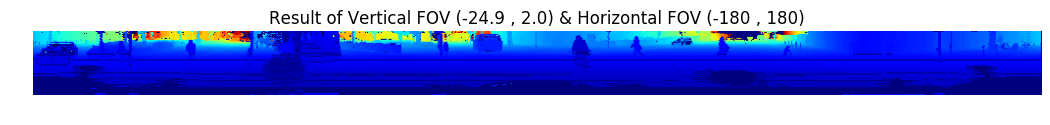

In [2]:
def normalize_depth(val, min_v, max_v):
    """ 
    print 'nomalized depth value' 
    nomalize values to 0-255 & close distance value has high value. (similar to stereo vision's disparity map)
    """
    return (((max_v - val) / (max_v - min_v)) * 255).astype(np.uint8)

def normalize_val(val, min_v, max_v):
    """ 
    print 'nomalized depth value' 
    nomalize values to 0-255 & close distance value has high value. (similar to stereo vision's disparity map)
    """
    return (((val - min_v) / (max_v - min_v)) * 255).astype(np.uint8)

def in_h_range_points(points, m, n, fov):
    """ extract horizontal in-range points """
    return np.logical_and(np.arctan2(n,m) > (-fov[1] * np.pi / 180), \
                          np.arctan2(n,m) < (-fov[0] * np.pi / 180))

def in_v_range_points(points, m, n, fov):
    """ extract vertical in-range points """
    return np.logical_and(np.arctan2(n,m) < (fov[1] * np.pi / 180), \
                          np.arctan2(n,m) > (fov[0] * np.pi / 180))

def fov_setting(points, x, y, z, dist, h_fov, v_fov):
    """ filter points based on h,v FOV  """
    
    if h_fov[1] == 180 and h_fov[0] == -180 and v_fov[1] == 2.0 and v_fov[0] == -24.9:
        return points
    
    if h_fov[1] == 180 and h_fov[0] == -180:
        return points[in_v_range_points(points, dist, z, v_fov)]
    elif v_fov[1] == 2.0 and v_fov[0] == -24.9:        
        return points[in_h_range_points(points, x, y, h_fov)]
    else:
        h_points = in_h_range_points(points, x, y, h_fov)
        v_points = in_v_range_points(points, dist, z, v_fov)
        return points[np.logical_and(h_points, v_points)]

def velo_points_2_pano(points, v_res, h_res, v_fov, h_fov, depth=False):

    # Projecting to 2D
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    dist = np.sqrt(x ** 2 + y ** 2 + z ** 2)

    # project point cloud to 2D point map
    x_img = np.arctan2(-y, x) / (h_res * (np.pi / 180))
    y_img = -(np.arctan2(z, dist) / (v_res * (np.pi / 180)))

    """ filter points based on h,v FOV  """
    x_img = fov_setting(x_img, x, y, z, dist, h_fov, v_fov)
    y_img = fov_setting(y_img, x, y, z, dist, h_fov, v_fov)
    dist = fov_setting(dist, x, y, z, dist, h_fov, v_fov)

    x_size = int(np.ceil((h_fov[1] - h_fov[0])/h_res))
    y_size = int(np.ceil((v_fov[1] - v_fov[0])/v_res))
    
    # shift negative points to positive points (shift minimum value to 0)
    x_offset = h_fov[0] / h_res
    x_img = np.trunc(x_img - x_offset).astype(np.int32)
    y_offset = ((v_fov[1] / v_res))
    y_fine_tune = 1
    y_img = np.trunc(y_img + y_offset + y_fine_tune).astype(np.int32)

    if depth == True:
        # nomalize distance value & convert to depth map
        dist = normalize_depth(dist, min_v=0, max_v=120)
    else:
        dist = normalize_val(dist, min_v=0, max_v=120)

    # array to img
    img = np.zeros([y_size + 1, x_size + 1], dtype=np.uint8)
    img[y_img, x_img] = dist
    
    return img

v_fov, h_fov = (-24.9, 2.0), (-180,180)
pano_img = velo_points_2_pano(velo_points, v_res=0.42, h_res=0.35, v_fov=v_fov, h_fov=h_fov, depth = False)

# display result image
plt.subplots(1,1, figsize = (13,3) )
plt.title("Result of Vertical FOV ({} , {}) & Horizontal FOV ({} , {})".format(v_fov[0],v_fov[1],h_fov[0],h_fov[1]))
plt.imshow(pano_img)
plt.axis('off')

print(pano_img.shape)

(31, 401)


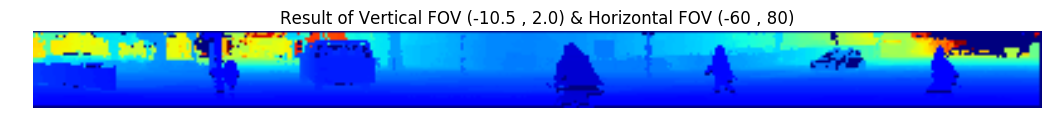

In [3]:
""" different vertical, horizontal FOV's result """
v_fov, h_fov = (-10.5,2.0), (-60, 80)
pano_img = velo_points_2_pano(velo_points, v_res=0.42, h_res=0.35, v_fov=v_fov, h_fov=h_fov, depth = False)

# display result image
plt.subplots(1,1, figsize = (13,3) )
plt.title("Result of Vertical FOV ({} , {}) & Horizontal FOV ({} , {})".format(v_fov[0],v_fov[1],h_fov[0],h_fov[1]))
plt.imshow(pano_img)
plt.axis('off')

print(pano_img.shape)

## Save panorama video

In [4]:
import glob
import cv2

lidar_points = glob.glob('./velodyne_points/data/*.bin')

""" save panorama video """
fourcc = cv2.VideoWriter_fourcc(*'XVID')
vid = cv2.VideoWriter('pano.mp4', fourcc, 25.0, (1030, 66), False)

for point in lidar_points:
    velo = load_from_bin(point)
    img = velo_points_2_pano(velo, v_res=0.42, h_res=0.35, v_fov=(-24.9, 2.0), h_fov=(-180,180), depth = True)
    vid.write(img)

print('video saved')
vid.release()   

video saved


## Display panorama video

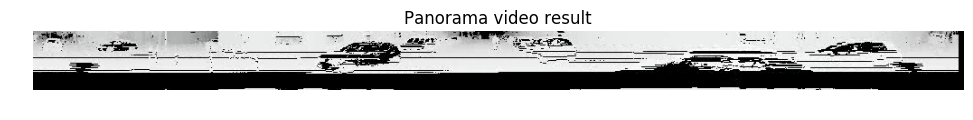

In [5]:
from IPython.display import clear_output

""" display video """
vid = cv2.VideoCapture("./pano.mp4")

while(True):
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12,3))
    
    plt.title("Panorama video result")
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()